# Try out gradio

**Load and try the model**

In [1]:
# Prerequisites
from tabulate import tabulate
from transformers import pipeline
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the model and create a pipeline for zero-shot classification (1min loading + classifying with 89 labels)
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# get candidate labels
with open("packing_label_structure.json", "r") as file:
    candidate_labels = json.load(file)
keys_list = list(candidate_labels.keys())

# Load test data (in list of dictionaries)
with open("test_data.json", "r") as file:
    packing_data = json.load(file)
# Extract all trip descriptions and trip_types
trip_descriptions = [trip['description'] for trip in packing_data]
trip_types = [trip['trip_types'] for trip in packing_data]

# Access the first trip description
first_trip = trip_descriptions[1]
# Get the packing list for the secondfirst trip
first_trip_type = trip_types[1]

print(f"First trip: {first_trip} \n")
print(f"Trip type: {first_trip_type}")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


First trip: We are a couple in our thirties traveling to Vienna for a three-day city trip. We’ll be staying at a friend’s house and plan to explore the city by sightseeing, strolling through the streets, visiting markets, and trying out great restaurants and cafés. We also hope to attend a classical music concert. Our journey to Vienna will be by train. 

Trip type: ['city trip', ['sightseeing'], 'variable weather / spring / autumn', 'luxury (including evening wear)', 'casual', 'indoor', 'no vehicle', 'no special condition', '3 days']


In [2]:
# Create an empty DataFrame with specified columns
df = pd.DataFrame(columns=['superclass', 'pred_class'])
cutoff = 0.5  # used to choose which activities are relevant

# fill DataFrame
for i, key in enumerate(keys_list):
    # Run the classification (ca 30 seconds classifying)
    if key == 'activities':
        result = classifier(first_trip, candidate_labels[key], multi_label=True)
        indices = [i for i, score in enumerate(result['scores']) if score > cutoff]
        classes = [result['labels'][i] for i in indices]
    else:
        result = classifier(first_trip, candidate_labels[key])
        classes = result["labels"][0]
    print(result)
    print(classes)
    print(i)
    df.loc[i] = [key, classes]

df['true_class'] = first_trip_type

{'sequence': 'We are a couple in our thirties traveling to Vienna for a three-day city trip. We’ll be staying at a friend’s house and plan to explore the city by sightseeing, strolling through the streets, visiting markets, and trying out great restaurants and cafés. We also hope to attend a classical music concert. Our journey to Vienna will be by train.', 'labels': ['city trip', 'micro-adventure / weekend trip', 'cultural exploration', 'festival trip', 'digital nomad trip', 'nature escape', 'hut trek (summer)', 'hut trek (winter)', 'yoga / wellness retreat', 'ski tour / skitour', 'long-distance hike / thru-hike', 'road trip (car/camper)', 'snowboard / splitboard trip', 'beach vacation', 'camping trip (campground)', 'camping trip (wild camping)'], 'scores': [0.43876224756240845, 0.28949078917503357, 0.2296781688928604, 0.013231690041720867, 0.006261605303734541, 0.0048823230899870396, 0.004273542668670416, 0.003523954190313816, 0.002200624207034707, 0.0017751322593539953, 0.0012460413

In [3]:
pd.set_option('display.width', 1000) 
pd.set_option('display.max_columns', None)
df['same_value'] = df['pred_class'] == df['true_class']
print(df)

           superclass                          pred_class                          true_class   same
0       activity_type                           city trip                           city trip   True
1          activities              [sightseeing, running]                       [sightseeing]  False
2   climate_or_season  variable weather / spring / autumn  variable weather / spring / autumn   True
3    style_or_comfort                          ultralight     luxury (including evening wear)  False
4          dress_code                        conservative                              casual  False
5       accommodation                huts with half board                              indoor  False
6      transportation                             vehicle                          no vehicle  False
7  special_conditions                        pet-friendly                no special condition  False
8    trip_length_days                              3 days                              3 da

In [4]:
# accuracy excluding activities
correct = sum(df.loc[df.index != 1, 'same_value'])
total = len(df['same_value'])
accuracy = correct/total
print("Accuracy (excluding activities):", accuracy)

Accuracy (excluding activities): 0.3333333333333333


In [5]:
pred_class = df.loc[df.index == 1, 'pred_class'].iloc[0]
true_class = df.loc[df.index == 1, 'true_class'].iloc[0]
correct = [label for label in pred_class if label in true_class]

num_correct = len(correct)
correct_perc = num_correct/len(true_class)

num_pred = len(pred_class)
wrong_perc = (num_pred - num_correct)/num_pred

print("Percentage of true classes that were identified:", correct_perc)
print("Percentage of predicted classes that were wrong:", wrong_perc)

Percentage of true classes that were identified: 1.0
Percentage of predicted classes that were wrong: 0.5


In [10]:
# write function that returns pandas data frame with predictions

cut_off = 0.5  # used to choose which activities are relevant

def pred_trip(trip_descr, trip_type, cut_off):
    # Create an empty DataFrame with specified columns
    df = pd.DataFrame(columns=['superclass', 'pred_class'])
    for i, key in enumerate(keys_list):
        if key == 'activities':
            result = classifier(trip_descr, candidate_labels[key], multi_label=True)
            indices = [i for i, score in enumerate(result['scores']) if score > cut_off]
            classes = [result['labels'][i] for i in indices]
        else:
            result = classifier(trip_descr, candidate_labels[key])
            classes = result["labels"][0]
        print(result)
        print(classes)
        print(i)
        df.loc[i] = [key, classes]
    df['true_class'] = trip_type
    return df

In [7]:
test = pred_trip(first_trip, first_trip_type, cut_off = 0.5)

{'sequence': 'We are a couple in our thirties traveling to Vienna for a three-day city trip. We’ll be staying at a friend’s house and plan to explore the city by sightseeing, strolling through the streets, visiting markets, and trying out great restaurants and cafés. We also hope to attend a classical music concert. Our journey to Vienna will be by train.', 'labels': ['city trip', 'micro-adventure / weekend trip', 'cultural exploration', 'festival trip', 'digital nomad trip', 'nature escape', 'hut trek (summer)', 'hut trek (winter)', 'yoga / wellness retreat', 'ski tour / skitour', 'long-distance hike / thru-hike', 'road trip (car/camper)', 'snowboard / splitboard trip', 'beach vacation', 'camping trip (campground)', 'camping trip (wild camping)'], 'scores': [0.43876224756240845, 0.28949078917503357, 0.2296781688928604, 0.013231690041720867, 0.006261605303734541, 0.0048823230899870396, 0.004273542668670416, 0.003523954190313816, 0.002200624207034707, 0.0017751322593539953, 0.0012460413

In [20]:
# write function for accuracy, perc true classes identified and perc wrong pred classes

def perf_measure(df):
    df['same_value'] = df['pred_class'] == df['true_class']
    correct = sum(df.loc[df.index != 1, 'same_value'])
    total = len(df['same_value'])
    accuracy = correct/total
    pred_class = df.loc[df.index == 1, 'pred_class'].iloc[0]
    true_class = df.loc[df.index == 1, 'true_class'].iloc[0]
    correct = [label for label in pred_class if label in true_class]
    num_correct = len(correct)
    correct_perc = num_correct/len(true_class)
    num_pred = len(pred_class)
    wrong_perc = (num_pred - num_correct)/num_pred
    df_perf = pd.DataFrame({
    'accuracy': [accuracy],
    'true_ident': [correct_perc],
    'false_pred': [wrong_perc]
    })
    return(df_perf)

In [22]:
print(test)
print(perf_measure(test))

           superclass                          pred_class                          true_class   same
0       activity_type                           city trip                           city trip   True
1          activities              [sightseeing, running]                       [sightseeing]  False
2   climate_or_season  variable weather / spring / autumn  variable weather / spring / autumn   True
3    style_or_comfort                          ultralight     luxury (including evening wear)  False
4          dress_code                        conservative                              casual  False
5       accommodation                huts with half board                              indoor  False
6      transportation                             vehicle                          no vehicle  False
7  special_conditions                        pet-friendly                no special condition  False
8    trip_length_days                              3 days                              3 da

**Now do the same for all trips**

In [11]:
result_list = []
performance = pd.DataFrame(columns=['accuracy', 'true_ident', 'false_pred'])
 
for i in range(len(trip_descriptions)):
    current_trip = trip_descriptions[i]
    current_type = trip_types[i]
    df = pred_trip(current_trip, current_type, cut_off = 0.5)
    print(df)
    
    # accuracy, perc true classes identified and perc wrong pred classes
    performance.loc[i] = perf_measure(df)
    print(performance)
    
    result_list.append(df)

{'sequence': 'I am planning a trip to Greece with my boyfriend, where we will visit two islands. We have booked an apartment on each island for a few days and plan to spend most of our time relaxing. Our main goals are to enjoy the beach, try delicious local food, and possibly go on a hike—if it’s not too hot. We will be relying solely on public transport. We’re in our late 20s and traveling from the Netherlands.', 'labels': ['beach vacation', 'micro-adventure / weekend trip', 'nature escape', 'digital nomad trip', 'cultural exploration', 'yoga / wellness retreat', 'festival trip', 'long-distance hike / thru-hike', 'hut trek (summer)', 'city trip', 'road trip (car/camper)', 'ski tour / skitour', 'camping trip (campground)', 'snowboard / splitboard trip', 'camping trip (wild camping)', 'hut trek (winter)'], 'scores': [0.37631064653396606, 0.35016775131225586, 0.13397355377674103, 0.031636204570531845, 0.031270742416381836, 0.012846449390053749, 0.012699575163424015, 0.009526746347546577

In [23]:
print(result_list)
print(performance)
print(type(performance))

[           superclass                              pred_class                                        true_class   same
0       activity_type                          beach vacation                                    beach vacation   True
1          activities  [going to the beach, relaxing, hiking]  [swimming, going to the beach, relaxing, hiking]  False
2   climate_or_season               warm destination / summer                         warm destination / summer   True
3    style_or_comfort                              minimalist                     lightweight (but comfortable)  False
4          dress_code                                  casual                                            casual   True
5       accommodation                    huts with half board                                            indoor  False
6      transportation                                 vehicle                                        no vehicle  False
7  special_conditions               off-grid / 

In [25]:
print(type(result_list))
print(type(result_list[0]))

<class 'list'>
<class 'pandas.core.frame.DataFrame'>


In [37]:
# Extract "same_value" column from each DataFrame
sv_columns = [df['same'] for df in result_list]  # 'same' needs to be changed
sv_columns.insert(0, result_list[0]['superclass'])

# Combine into a new DataFrame (columns side-by-side)
sv_df = pd.concat(sv_columns, axis=1)

print(sv_df)

           superclass   same   same   same   same   same   same   same   same   same   same
0       activity_type   True   True  False   True   True  False   True   True   True   True
1          activities  False  False  False  False  False  False  False  False  False  False
2   climate_or_season   True   True   True  False   True  False  False   True   True  False
3    style_or_comfort  False  False   True  False  False   True   True  False   True  False
4          dress_code   True  False   True   True   True   True   True  False   True  False
5       accommodation  False  False  False  False  False   True   True  False  False   True
6      transportation  False  False  False  False  False   True   True   True  False   True
7  special_conditions  False  False  False  False  False  False  False  False  False  False
8    trip_length_days  False   True   True   True   True  False  False  False  False   True


In [35]:
df['row_mean'] = df.mean(axis=1)


0         activity_type
1            activities
2     climate_or_season
3      style_or_comfort
4            dress_code
5         accommodation
6        transportation
7    special_conditions
8      trip_length_days
Name: superclass, dtype: object


accuracy      0.411111
true_ident    0.708333
false_pred    0.400000
dtype: float64


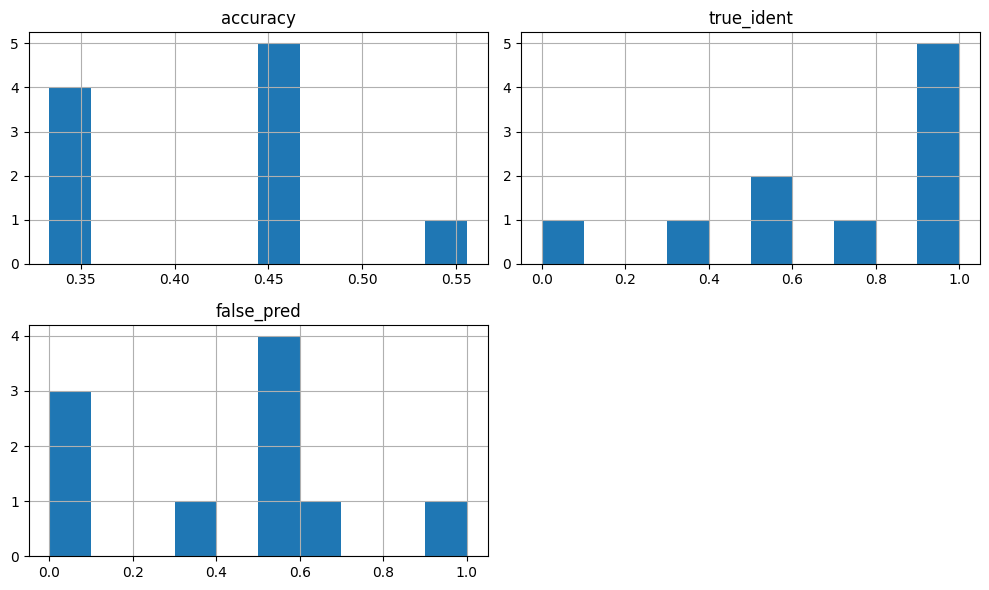

In [24]:
# Compute mean for each column
column_means = performance.mean()
print(column_means)

# Plot histograms for all numeric columns
performance.hist(bins=10, figsize=(10, 6))
plt.tight_layout()
plt.show()

In [ ]:
# whcih superclass most mistakes?

**Use gradio for user input**

In [66]:
# use model with gradio
from transformers import pipeline
import gradio as gr

# make a function for what I am doing
def classify(text):
    df = pd.DataFrame(columns=['Superclass', 'class'])
    for i, key in enumerate(keys_list):
        # Run the classification (ca 30 seconds classifying)
        if key == 'activities':
            result = classifier(text, candidate_labels[key], multi_label=True)
            classes = [result['labels'][i] for i in indices]
        else:
            result = classifier(text, candidate_labels[key])
            classes = result["labels"][0]
        print(i)
        df.loc[i] = [key, classes]

    return df

demo = gr.Interface(
    fn=classify,
    inputs="text",
    outputs="dataframe",
    title="Zero-Shot Classification",
    description="Enter a text describing your trip",
)

# Launch the Gradio app
if __name__ == "__main__":
    demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://aa06d5d85ffadaa92b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8


Use model with gradio

In [4]:
# Define the Gradio interface
def classify(text):
    return classifier(text, class_labels)

demo = gr.Interface(
    fn=classify,
    inputs="text",
    outputs="json",
    title="Zero-Shot Classification",
    description="Enter a text describing your trip",
)

# Launch the Gradio app
if __name__ == "__main__":
    demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://0f70ba5369d721cf8f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
